# FLCs

Here we will investigate correlations between any FLCs and PSO search behaviour.

Might be better to investigate one FLC at a time.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from termcolor import colored
import sys

In [3]:
from results import benchmarks, psos, drocs

getting db connection...
getting db cursor...
db ready.


# Ruggedness

## Macro-ruggedness (FEM_0.1)

In [4]:
from matplotlib import pyplot as plt
from matplotlib import colors as colors
from matplotlib.pyplot import cm
from matplotlib.patches import Polygon
import numpy as np
from scipy.spatial import ConvexHull


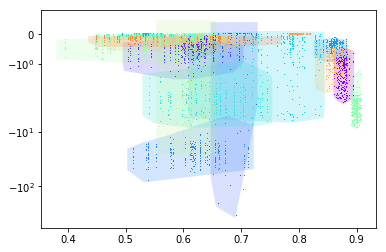

In [8]:
from results.flc.ruggedness import fem_0_1, fem_0_01


# Stick to 25 particles, 5 dimensions

swarm_size = 25
D = 5
num_iterations = 2000

es = range(30)

# Per PSO

pso_names = psos.all_names
# pso_names = ['gbest_pso']
    
colors=iter(cm.rainbow(np.linspace(0,1,len(benchmarks.all_names))))
    
for (i, benchmark_name) in enumerate(benchmarks.all_names):
    benchmark = benchmarks.get(benchmark_name)
    
    if not benchmark.is_dimensionality_valid(5):
        continue

    if benchmark_name == 'rana':
        # Aint nobody got time for that!
        continue

    color=next(colors)

    _flcs = []
    _drocs = []
    
    for pso_name in pso_names:
#         print pso_name

        
        for e in es:

            _flc = fem_0_01.get(
                benchmark_name,
                D,
                e)

            _droc = drocs.get(
                pso_name,
                swarm_size,
                benchmark_name,
                D,
                num_iterations,
                e)

            _flcs.append(_flc)
            _drocs.append(_droc)

    plt.yscale('symlog')
    plt.plot(_flcs, _drocs, ',', color=color)

    points = np.column_stack((_flcs, _drocs))

    hull = ConvexHull(points)

    cent = np.mean(points, 0)
    pts = []
    for pt in points[hull.simplices]:
        pts.append(pt[0].tolist())
        pts.append(pt[1].tolist())

    pts.sort(key=lambda p: np.arctan2(p[1] - cent[1], p[0] - cent[0]))
    pts = pts[0::2]  # Deleting duplicates
    pts.insert(len(pts), pts[0])
    k = 1.1
    poly = Polygon(k*(np.array(pts)- cent) + cent, fc=color, alpha=0.2)
    poly.set_capstyle('round')
    plt.gca().add_patch(poly)
    
plt.show()


This is a very nice plot! Unfortunately, it doesn't average the DRoCs or FLC values, and then groups individual DRoC and FLC values as if they were related, which is not the case. Maybe I could find a way to create something _like_ this, though?

Each shaded bit combines all the readings for a single benchmark (so all the points in a shaded bit are from different PSOs, sort of -- see previous paragraph). This gives a nice picture of the range of FLC and DRoC values for each benchmark, which you don't get when you average the FLC values, since that compresses them into a single line.

Maybe we should just draw a square with corners in the min/max combos for all flcs and drocs per benchmark?

Also, the focus of this isn't right. It shows us where each benchmark function falls in the FLC range, which is a good departure point if you want to talk about the FLCs exhibited by each benchmark; however, we're trying to find correlations between FLCs and DRoCs, so we should focus on how the DRoC of an individual PSO changes along with FLCs of the various benchmark functions it is used on.

## Combine readings for all PSOs for all benchmark functions

These are scatterplots with a point for each (flc, droc) obtained for each PSO, for each benchmark function.

We want to see whether changes in FLCs result in changes in DRoCs. So we "group" all DRoCs for the same PSO taken on different benchmark functions. We average those DRoCs, as well as the FLC measurements taken on each benchmark function, giving us a (droc, flc)-pair for each (PSO, benchmark)-pair. (Note that we can't map individual DRoC measurements to individual FLC measurements as they are not ordinally related.)

In [6]:
from results import psos, benchmarks, drocs

### Constant params:

# PSOs to use:
pso_names = psos.all_names
# pso_names = ['gbest_pso']

# Swarm size to use:
swarm_size = 25

# Benchmarks to use:
benchmark_names = benchmarks.all_names
benchmark_names = [n for n in benchmark_names if n != 'rana'] # Aint nobody got time for that!

# Dimensionality to use:
dimensionality = 2

# Number of iterations:
num_iterations = 2000

# Experiments:
es = range(30)

## Macro-ruggedness (FEM_0.1)


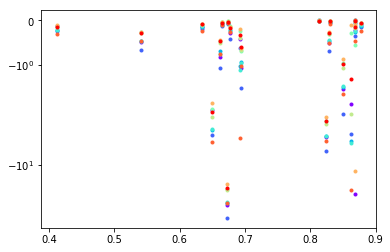

In [110]:
# There will be a color for each PSO.
num_colors = len(pso_names)
colors=iter(cm.rainbow(np.linspace(0, 1, num_colors)))

for pso_name in pso_names:
    # All points for this PSO will use the same color.
    color = next(colors)
    
    # Collect all avg drocs to plot for this PSO.
    avg_drocs = []
    
    # Collect all avg FLCs to plot for this PSO.
    avg_flcs = []
    
    # Collect an avg DRoC and FLC value for each benchmark function:
    for benchmark_name in benchmark_names:
        benchmark = benchmarks.get(benchmark_name)
        if not benchmark.is_dimensionality_valid(5):
            continue
        
        # A DRoC- and FLC-value is collected for each experiment.
        # They are then averaged.
        all_drocs = []
        all_flcs = []
        
        for e in es:
            flc = fem_0_1.get(
                benchmark_name,
                D,
                e)

            droc = drocs.get(
                pso_name,
                swarm_size,
                benchmark_name,
                D,
                num_iterations,
                e)
            
            all_flcs.append(flc)
            all_drocs.append(droc)
        
        avg_droc = np.average(all_drocs)
        avg_drocs.append(avg_droc)
#         avg_drocs += all_drocs
        
        avg_flc = np.average(all_flcs)
        avg_flcs.append(avg_flc)
#         avg_flcs += all_flcs
    
    # All average values for this PSO are collected.
    # Add the average values for this PSO to the plot,
    # and draw a polygon around those values.
        
    plt.yscale('symlog')

    points = np.column_stack((avg_flcs, avg_drocs))
    plt.plot(points[:,0], points[:,1], '.', color=color)

#     hull = ConvexHull(points)

#     cent = np.mean(points, 0)
#     pts = []
#     for pt in points[hull.simplices]:
#         pts.append(pt[0].tolist())
#         pts.append(pt[1].tolist())

#     pts.sort(key=lambda p: np.arctan2(p[1] - cent[1], p[0] - cent[0]))
#     pts = pts[0::2]  # Deleting duplicates
#     pts.insert(len(pts), pts[0])
#     k = 1.1
#     poly = Polygon(k*(np.array(pts)- cent) + cent, fc=color, alpha=0.2)
#     poly.set_capstyle('round')
#     plt.gca().add_patch(poly)
    
plt.show()  
    

This seems to show that, for each PSO, there are cases all over the place.

We may want to split this up further into benchmarks per pso -- so generate a plot for each PSO? But we only have one average value per PSO per benchmark? Let's see what we get though?


alternative_barebones_pso


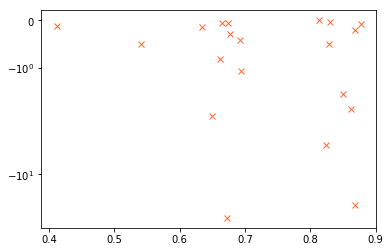


barebones_pso


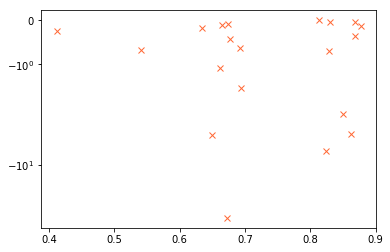


gbest_pso


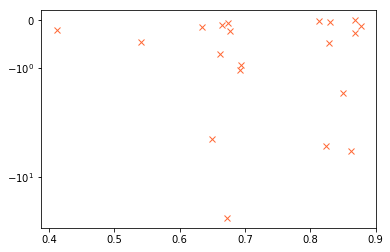


gc_gbest_pso


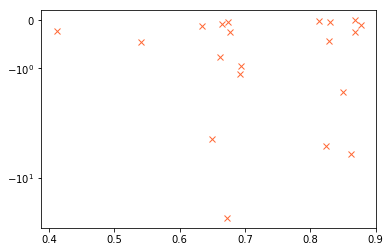


gc_lbest_pso


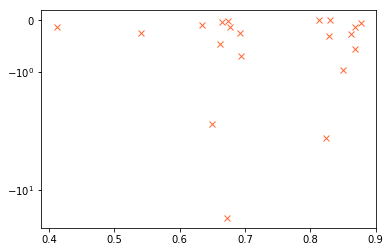


gc_von_neumann_pso


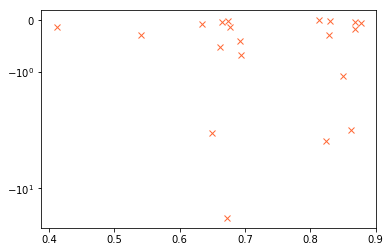


lbest_pso


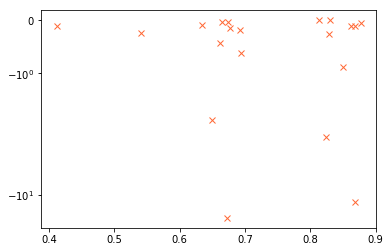


social_only_pso


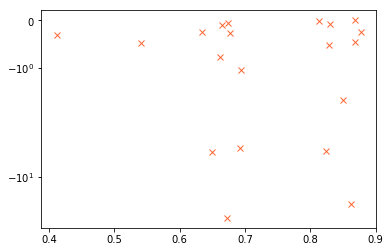


von_neumann_pso


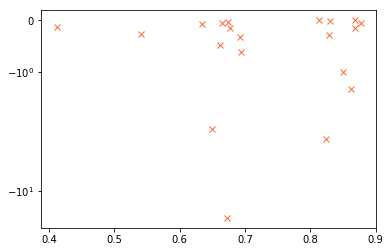

In [113]:
for pso_name in pso_names:
    # Collect all avg drocs to plot for this PSO.
    avg_drocs = []
    
    # Collect all avg FLCs to plot for this PSO.
    avg_flcs = []
    
    # Collect an avg DRoC and FLC value for each benchmark function:
    for benchmark_name in benchmark_names:
        benchmark = benchmarks.get(benchmark_name)
        if not benchmark.is_dimensionality_valid(5):
            continue
        
        # A DRoC- and FLC-value is collected for each experiment.
        # They are then averaged.
        all_drocs = []
        all_flcs = []
        
        for e in es:
            flc = fem_0_1.get(
                benchmark_name,
                D,
                e)

            droc = drocs.get(
                pso_name,
                swarm_size,
                benchmark_name,
                D,
                num_iterations,
                e)
            
            all_flcs.append(flc)
            all_drocs.append(droc)
        
        avg_droc = np.average(all_drocs)
        avg_drocs.append(avg_droc)
        
        avg_flc = np.average(all_flcs)
        avg_flcs.append(avg_flc)
    
    print ''
    print pso_name
    plt.yscale('symlog')
    plt.plot(avg_flcs, avg_drocs, 'x', color=color)
    plt.show()
    

Each PSO's pattern is quite similar. Maybe we can figure out where the patterns are coming from by grouping by benchmarks first.

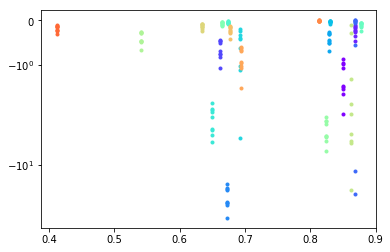

In [111]:
# There will be a color for each PSO.
num_colors = len(benchmark_names)
colors=iter(cm.rainbow(np.linspace(0, 1, num_colors)))

for benchmark_name in benchmark_names:
    benchmark = benchmarks.get(benchmark_name)
    if not benchmark.is_dimensionality_valid(5):
        continue
        
    # All points for this PSO will use the same color.
    color = next(colors)
    
    # Collect all avg drocs to plot for this PSO.
    avg_drocs = []
    
    # Collect all avg FLCs to plot for this PSO.
    avg_flcs = []
    
    # Collect an avg DRoC and FLC value for each benchmark function:
    for pso_name in pso_names:
        # A DRoC- and FLC-value is collected for each experiment.
        # They are then averaged.
        all_drocs = []
        all_flcs = []
        
        for e in es:
            flc = fem_0_1.get(
                benchmark_name,
                D,
                e)

            droc = drocs.get(
                pso_name,
                swarm_size,
                benchmark_name,
                D,
                num_iterations,
                e)
            
            all_flcs.append(flc)
            all_drocs.append(droc)
        
        avg_droc = np.average(all_drocs)
        avg_drocs.append(avg_droc)
        
        avg_flc = np.average(all_flcs)
        avg_flcs.append(avg_flc)
    
    # All average values for this PSO are collected.
    # Add the average values for this PSO to the plot,
    # and draw a polygon around those values.
        
    plt.yscale('symlog')
    plt.plot(avg_flcs, avg_drocs, '.', color=color)
#     plt.plot(avg_flcs, avg_drocs, color=color, linestyle='-')

    
plt.show()  


The droc values appear as vertical lines because we get an avg DRoC value for each PSO, and we run through each PSO for each benchmark function, and the avg FLC for each benchmark function is constant-ish.

So this shows as, for each benchmark function, what the average FLC value was, and what the average DRoC was for each PSO. It's something!

This plot is actually the same as the one grouped by benchmark (shocker!), but here the color groups highlight the groups of values per benchmark function.

We should actually be looking at this in terms of not just FLCs, but also functions; it seems like some functions promote quicker convergence than others at the same level of ruggedness, and so the associated DRoCs may be resultant of other FLCs (not ruggedness), or even a combination.

Can we plot various FLCs together, with a new color per FLC?

- A new plot for each benchmark function
- Each plot combines different-colored scatterplots for different FLCs
- Each scatterplot shows the (flc-value, droc-value) for each function; this would have to be normalised somehow.

Otherwise, maybe we should try and flip the dependency. For each DRoC value, what are all the corresponding FLCs? This might paint a clearer picture of all the constituent causes?

Check out https://towardsdatascience.com/the-art-of-effective-visualization-of-multi-dimensional-data-6c7202990c57

- Pair-wise scatter plots


Let's take seaborn's pairwise plots for a spin!

In [9]:
from results.flc.neutrality import pn, lsn

_drocs = []
_fem0_1s = []
_fem0_01s = []
_pns = []
_lsns = []


for pso_name in pso_names:
    for benchmark_name in benchmark_names:
        if not benchmarks.get(benchmark_name).is_dimensionality_valid(dimensionality):
            continue
        
        for e in es:
            _droc = drocs.get(
                pso_name,
                swarm_size,
                benchmark_name,
                dimensionality,
                num_iterations,
                e
            )
            
            _fem0_1 = fem_0_1.get(
                benchmark_name,
                dimensionality,
                e)
            
            _fem0_01 = fem_0_01.get(
                benchmark_name,
                dimensionality,
                e)
            
            _pn = pn.get(
                benchmark_name,
                dimensionality,
                e)
            
            _lsn = lsn.get(
                benchmark_name,
                dimensionality,
                e)
            
            _drocs.append(_droc)
            _fem0_1s.append(_fem0_1)
            _fem0_01s.append(_fem0_01)
            _pns.append(_pn)
            _lsns.append(_lsn)


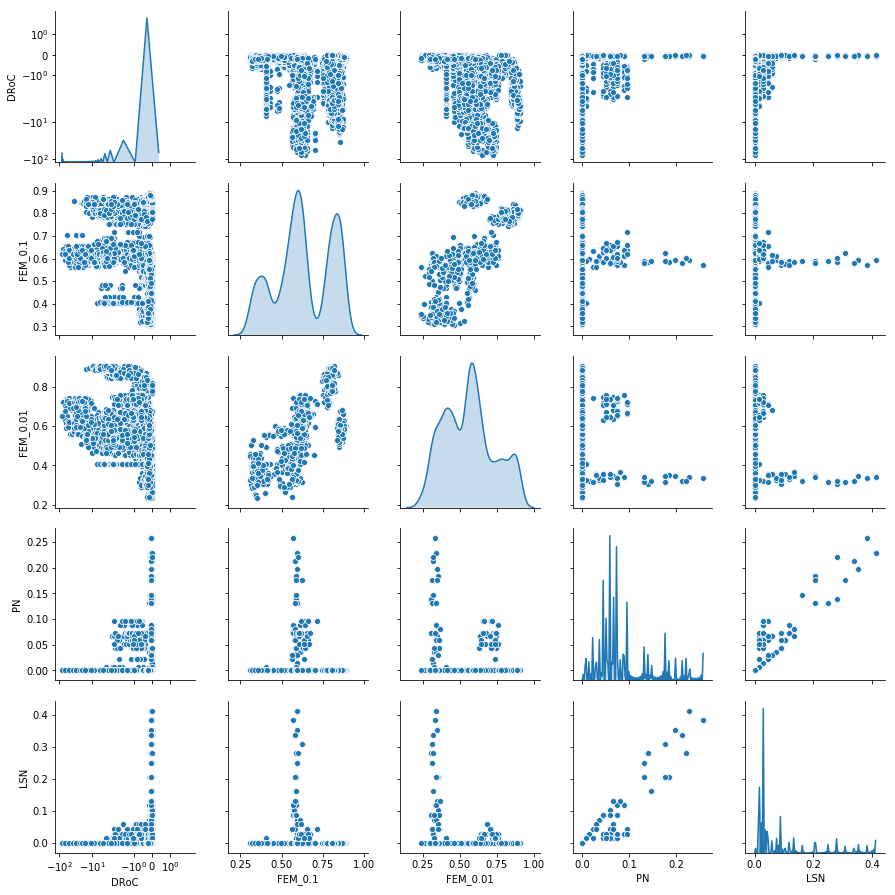

In [21]:
import seaborn as sns
from pandas import DataFrame

_drocs = np.array(_drocs)
_fem0_1s = np.array(_fem0_1s)
_fem0_01s = np.array(_fem0_01s)
_pns = np.array(_pns)
_lsns = np.array(_lsns)

# data = np.array([_drocs, _fem0_1s, _fem0_01s])
data = np.column_stack((_drocs, _fem0_1s, _fem0_01s, _pns, _lsns))
columns = ['DRoC', 'FEM_0.1', 'FEM_0.01', 'PN', 'LSN']
data = DataFrame(data, columns=columns)

pp = sns.pairplot(data, diag_kind="kde", diag_kws=dict(shade=True))
print pp
for i in range(len(pp.axes)):
    for j in range(len(pp.axes)):
        if i == 0:
            pp.axes[i,j].set(yscale='symlog')
        elif j == 0:
            pp.axes[i,j].set(xscale='symlog')

Looks like we'll be using the same sort of data for analysis here. Let's just get and format it here.

We want:
- For each FLC measure, the measurements across all functions and all PSOs
- For each FLC measure, for each PSO, the measurements across all functions

We can probably get the former from the latter, so let's build the latter first.

It'll be structured like this:

- FEM_0.1
    - Ackley
        - 0: <value>
        - 1: <value>
        ...
    - Alpine
        ...
   ...
- FEM_0.01
    ...
...


In [42]:
import pandas as pd

fem0_1_ackley = np.random.randn(6)
fem0_1_alpine = np.random.randn(6)

fem0_1 = {'ackley': fem0_1_ackley, 'alpine': fem0_1_alpine}

fem0_01_ackley = np.random.randn(6)
fem0_01_alpine = np.random.randn(6)

fem0_01 = {'ackley': fem0_01_ackley, 'alpine': fem0_01_alpine}

flcs = {'fem0_1': fem0_1, 'fem0_01': fem0_01}

df = pd.DataFrame(flcs)
df

# df['fem0_1']
# np.mean(df['fem0_1'])

,fem0_01,fem0_1
ackley,"[-0.204381589626, 1.23307730963, 0.56699749827...","[0.635642016574, -0.149536967869, -1.166595099..."
alpine,"[-0.102733437015, -0.801344269584, -0.19711276...","[-0.974214780531, 2.08097845979, -0.0678801170..."


In [74]:
from results.flc.ruggedness import fem_0_1 as fem0_1_results
from results.flc.ruggedness import fem_0_01 as fem0_01_results
from results.flc.neutrality import pn as pn_results
from results.flc.neutrality import lsn as lsn_results
from results import benchmarks, psos

all_bench_names = benchmarks.all_names
D = 5

# This is what we want:
fem0_1s = {}
for bench_name in all_bench_names:
    bench = benchmarks.get(bench_name)
    if not bench.is_dimensionality_valid(D):
        continue
    
    bench_values = {}
    for e in range(30):
        bench_value = fem0_1_results.get(
            bench_name,
            D,
            e)
        bench_values[e] = bench_value
    fem0_1s[bench_name] = bench_values
fem0_1s

# But we want it in a nicer way; like with list comprehensions

# Like this (with dummy data)
fem0_1s = dict((bench_name, bench_values) for bench_name, bench_values in zip(all_bench_names, [1, 2, 3]))

# Or maybe this
fem0_1s = dict(zip(all_bench_names, [1, 2, 3]))

# This is how we get the vals for a specific bench_name
def get_fem0_1s(bench_name, D, E=6):
    bench = benchmarks.get(bench_name)
    if not bench.is_dimensionality_valid(D):
        return np.full(E, np.nan)
    
    return [fem0_1_results.get(bench_name, D, e) for e in range(E)]

# This works:
[(bench_name, get_fem0_1s(bench_name, D)) for bench_name in all_bench_names]

fem0_1s = dict([(bench_name, get_fem0_1s(bench_name, D)) for bench_name in all_bench_names])
df = pd.DataFrame(fem0_1s)

# Maybe we can generalize the get_* part

def get_flc(measure, bench_name, D, E=6):
    bench = benchmarks.get(bench_name)
    if not bench.is_dimensionality_valid(D):
        return np.full(E, np.nan)
    
    return [measure.get(bench_name, D, e) for e in range(E)]

fem0_1s_ackley = get_flc(fem0_1_results, 'ackley', D)
fem0_1s_ackley

# nice.
# so now we can go

measures = [fem0_1_results, fem0_01_results, pn_results, lsn_results]
measure_names = ['fem0_1', 'fem0_01', 'pn', 'lsn']
data = {}
for (m, mn) in zip(measures, measure_names):
    data[mn] = dict((bn, get_flc(m, bn, D)) for bn in all_bench_names)
data

# Sweet!

# Can we list-comprehend it?

data = dict((mn, dict((bn, get_flc(m, bn, D)) for bn in all_bench_names)) for (m, mn) in zip(measures, measure_names))
data

df = pd.DataFrame(data)
df

# NIce!!!

,fem0_01,fem0_1,lsn,pn
ackley,"[0.881727353112, 0.878834732749, 0.88163163946...","[0.856617469706, 0.8640096387, 0.844420801759,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
alpine,"[0.641446484609, 0.651778012029, 0.61152740529...","[0.869082702393, 0.871652693704, 0.86510494598...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
beale,"[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]"
bohachevsky1_generalized,"[0.615977320029, 0.651657990848, 0.59548526949...","[0.654966372659, 0.648772348846, 0.66216433600...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
eggholder_generalized,"[0.697058940177, 0.703925623713, 0.69015209970...","[0.869343861217, 0.880073863851, 0.85992678791...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
goldstein_price,"[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan]"
griewank,"[0.612379864756, 0.538243644175, 0.61844405260...","[0.669313283995, 0.67353276029, 0.657737113786...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
levy13_generalized,"[0.869629821843, 0.863902449861, 0.82865532115...","[0.826709226711, 0.836859226097, 0.82594634254...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
michalewicz,"[0.514477841732, 0.521947747278, 0.53357904740...","[0.834213145988, 0.821907555195, 0.82630702833...","[0.0183486238532, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.00366972477064, 0.0, 0.0, 0.0, 0.0, 0.0]"
pathological,"[0.788996899601, 0.828241770739, 0.78794853705...","[0.719795186086, 0.670947244751, 0.71770213437...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


Let's put that together

In [39]:
import numpy as np
import pandas as pd

from results.flc.ruggedness import fem_0_1 as fem0_1_results
from results.flc.ruggedness import fem_0_01 as fem0_01_results
from results.flc.neutrality import pn as pn_results
from results.flc.neutrality import lsn as lsn_results
from results.flc.gradients import g_avg as g_avg_results
from results.flc.gradients import g_dev as g_dev_results
from results.flc.funnels import dm as dm_results
from results.flc.deception import fdc as fdc_results
from results.flc.searchability import fci_soc as fci_soc_results
from results.flc.searchability import fci_cog as fci_cog_results
from results.flc.searchability import fci_sigma as fci_sigma_results
from results import benchmarks, psos

def get_flcs(measure, benchmark_name, D, E=30):
    benchmark = benchmarks.get(benchmark_name)
    if not benchmark.is_dimensionality_valid(D):
        return np.full(E, np.nan)
    return np.array([measure.get(
        benchmark_name, 
        D, 
        e) for e in range(E)])

measures = {
    'fem_0_1': fem0_1_results,
    'fem_0_01': fem0_01_results,
    'pn': pn_results,
    'lsn': lsn_results,
    'g_avg': g_avg_results,
    'g_dev': g_dev_results,
    'dm': dm_results,
    'fdc': fdc_results,
    'fci_soc': fci_soc_results,
    'fci_cog': fci_cog_results,
    'fci_sigma': fci_sigma_results,
}

D = 5

benchmark_names = []
for b in benchmarks.all_names:
    benchmark = benchmarks.get(b)
    if benchmark.is_dimensionality_valid(D):
        benchmark_names.append(b)

# All data
data = dict((m, dict((b, get_flcs(measures[m], b, D, E=30)) for b in benchmark_names )) for m in measures )
df = pd.DataFrame(data)

# Mean data
mdata = {}
for m in measures:
    measure_data = {}
    for b in benchmarks.all_names:
        b_vals = get_flcs(measures[m], b, D, E=30)
        b_vals = b_vals[~np.isnan(b_vals)]
        
        if len(b_vals) > 0:
            mean_b_val = np.mean(b_vals)
            measure_data[b] = mean_b_val
            
    mdata[m] = measure_data
    
b_data = {}
for b in benchmark_names:
    b_data[b] = b
mdata['benchmarks'] = b_data

mdf = pd.DataFrame(mdata)
mdf.dropna()
# mdf['benchmarks']
mdf

,benchmarks,dm,fci_cog,fci_sigma,fci_soc,fdc,fem_0_01,fem_0_1,g_avg,g_dev,lsn,pn
ackley,ackley,-0.210413,0.598800,0.022316,0.882333,0.677126,0.875296,0.850327,3.404967,2.569309,0.000000,0.000000
alpine,alpine,-0.128027,0.582867,0.059704,0.684667,0.352350,0.626740,0.869272,4.367782,3.400866,0.000000,0.000000
bohachevsky1_generalized,bohachevsky1_generalized,-0.235554,0.716000,0.028118,0.903667,0.810517,0.606664,0.661961,2.334511,1.624747,0.000000,0.000000
eggholder_generalized,eggholder_generalized,0.040770,0.579133,0.057752,0.609867,0.010225,0.691946,0.869069,6.442899,5.346894,0.000000,0.000000
griewank,griewank,-0.248920,0.701533,0.020495,0.909333,0.859234,0.614880,0.672460,2.491240,1.430133,0.000000,0.000000
levy13_generalized,levy13_generalized,-0.238976,0.608933,0.024860,0.912467,0.798101,0.860397,0.828212,2.600865,1.729351,0.000000,0.000000
michalewicz,michalewicz,-0.079169,0.603200,0.030100,0.704400,0.202347,0.530541,0.830335,4.276349,6.096269,0.004587,0.000917
pathological,pathological,-0.012731,0.542133,0.055647,0.596067,0.020014,0.760762,0.692978,3.601427,6.707853,0.000000,0.000000
quadric,quadric,-0.114674,0.759000,0.020927,0.780867,0.319355,0.652567,0.648798,1.893909,1.619894,0.000000,0.000000
quartic,quartic,-0.227153,0.703933,0.031138,0.851733,0.729693,0.556503,0.674523,2.219894,2.920930,0.000000,0.000000


## Parallel coords

In [46]:
# This works but the FLCs are not normalised.

# from pandas.plotting import parallel_coordinates
# pc = parallel_coordinates(mdf, 'benchmarks')

# Scaling attribute values to avoid few outiers

cols = ['fem_0_1', 'fem_0_01', 'pn', 'lsn', 'g_avg', 'g_dev', 'dm', 'fdc', 'fci_soc', 'fci_cog']
subset_df = mdf[cols]
# print mdf.head()

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

# This seems to scale... wrong.
scaled_df = ss.fit_transform(subset_df)
scaled_df = pd.DataFrame(scaled_df, columns=cols, index=mdf.index)
# print '----'
# print scaled_df.head()

# final_df = pd.concat([scaled_df, mdf['benchmarks']], axis=1)


from pandas.plotting import parallel_coordinates
pc = parallel_coordinates(final_df, 'index')


KeyError: 'index'

In [6]:
force_create = False

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
from termcolor import colored

# dir_path = os.path.dirname(os.path.realpath(__file__))

# # Hack to import mpy module from root dir:
# import sys
# mpy_dir = os.path.dirname(dir_path)
# for _ in range(3):
#     mpy_dir = os.path.dirname(mpy_dir)
# mpy_dir = mpy_dir + '/mpy'
# sys.path.insert(0, mpy_dir)

from results import psos, benchmarks
from results.flc.ruggedness import fem_0_1 as fem0_1_results
from results import drocs as droc_results

# Params

pso_names = psos.all_names
swarm_size = 25
dimensionality = 2
benchmark_names = []
for name in benchmarks.all_names:
    benchmark = benchmarks.get(name)
    if benchmark.is_dimensionality_valid(dimensionality):
        benchmark_names.append(name)
benchmark_names = sorted(benchmark_names)
num_iterations = 2000
num_experiments = 30

# FLCs
# as pandas series and a dataframe

flc_series = []
for benchmark_name in benchmark_names:
    series_vals = []
    for e in range(num_experiments):
        flc = fem0_1_results.get(benchmark_name, dimensionality, e)
        series_vals.append(flc)
    series = pd.Series(series_vals, name=benchmark_name)
    flc_series.append(series)

flc_df = pd.DataFrame(flc_series)

# DRoCs

# Normal (a benchmark per row; a PSO per col)
droc_dict = {}
for pso_name in pso_names:
    pso_dict = {}
    for benchmark_name in benchmark_names:
        droc_vals = []
        for e in range(num_experiments):
            droc = droc_results.get(pso_name, swarm_size, benchmark_name, dimensionality, num_iterations, e)
            droc_vals.append(droc)
        pso_dict[benchmark_name] = droc_vals
    droc_dict[pso_name] = pso_dict
droc_df = pd.DataFrame(droc_dict)

# Transposed (a PSO per row; a benchmark per col)
# NOTE: same as droc_df.transpose() ?
droc_dict = dict((benchmark_name, droc_df.loc[benchmark_name,]) for benchmark_name in benchmark_names)
droc_df_T = pd.DataFrame(droc_dict)


In [113]:
droc_df.head()

,alternative_barebones_pso,barebones_pso,gbest_pso,gc_gbest_pso,gc_lbest_pso,gc_von_neumann_pso,lbest_pso,social_only_pso,von_neumann_pso
ackley,"[-1.24741129117, -1.6105225604, -1.35828612556...","[-2.3243913616, -2.57840072513, -1.77662335924...","[-2.13872331499, -1.8746304094, -1.25176073604...","[-1.61794003621, -0.988359643278, -2.162114120...","[-1.06100606189, -0.997462885577, -0.887945988...","[-1.0678385702, -0.949714563796, -1.0672282632...","[-0.884190136576, -0.720145292691, -0.64343318...","[-1.66360810777, -1.81064449736, -1.6614955236...","[-1.02878601862, -0.52775391746, -1.0531799253..."
alpine,"[-0.203797763481, -0.141174701864, -0.14347017...","[-0.330628386099, -0.136264174918, -0.30267038...","[-0.325021442793, -0.362458974289, -0.15010969...","[-0.22184037583, -0.22685850193, -0.3031158290...","[-0.124686044417, -0.146258710426, -0.14143788...","[-0.0904699495828, -0.201985987585, -0.1633078...","[-0.0907546117094, -0.203969919849, -0.0834424...","[-0.528075561015, -0.559149527385, -0.53928957...","[-0.242015221257, -0.216851849257, -0.13559706..."
bohachevsky1_generalized,"[-0.814275879017, -0.656697154717, -0.72982791...","[-1.42525753662, -0.911306813798, -0.986773828...","[-1.31962976878, -0.729575327525, -0.541703877...","[-0.593892042685, -0.854276608482, -0.79020533...","[-0.470442286145, -0.390535286255, -0.13711543...","[-0.381578770892, -0.434690301271, -0.42846870...","[-0.390288792205, -0.499738044408, -0.40548873...","[-0.73495299802, -0.787794605992, -0.763252923...","[-0.418376441511, -0.44319741422, -0.552254520..."
eggholder_generalized,"[-7.53488080372e-05, -3.81160521498e-10, -345....","[-1.80165295274e-10, -7.70819121127e-07, -6.54...","[-3.39204429621e-20, -2.53345008067e-09, -0.05...","[-1.33402289493e-12, -2.38817754913e-06, -9.75...","[-1.01979590353e-09, -2.48211754187e-10, -0.46...","[-1.63677436503e-07, -9.00069939923e-08, -2.90...","[-10.0682344577, -9.13673530144e-06, -0.313665...","[-3.64668328284e-14, -2.03498599485e-16, -9.06...","[-2.8295375592e-13, -9.92823073097e-07, -1.708..."
griewank,"[-32.761080296, -33.0851981152, -32.1123338253...","[-47.9119162789, -44.8065101632, -55.480609033...","[-27.3901973443, -37.1676510101, -43.962151630...","[-25.5436538837, -26.7249987702, -25.527520709...","[-22.3756342841, -16.4463603169, -16.842120774...","[-18.3558915047, -22.0366138194, -20.294090762...","[-19.1264349422, -18.6141785485, -19.504359557...","[-24.695563885, -30.4768176548, -33.4564498977...","[-17.2577933594, -22.0948037703, -25.365258632..."


In [114]:
droc_df_T.head()

,ackley,alpine,bohachevsky1_generalized,eggholder_generalized,griewank,levy13_generalized,michalewicz,pathological,quadric,quartic,...,rastrigin,rosenbrock,salomon,schwefel_2_22,schwefel_2_26,skew_rastrigin,spherical,step,weierstrass,zakharov
alternative_barebones_pso,"[-1.24741129117, -1.6105225604, -1.35828612556...","[-0.203797763481, -0.141174701864, -0.14347017...","[-0.814275879017, -0.656697154717, -0.72982791...","[-7.53488080372e-05, -3.81160521498e-10, -345....","[-32.761080296, -33.0851981152, -32.1123338253...","[-0.472837330797, -0.525302033155, -0.43617446...","[-0.0351047053607, -0.035664135488, -0.0454764...","[-0.384629499614, -0.110982169288, -0.50360220...","[-1.4639328554, -1.50324288042, -3.66463155446...","[-0.0655540133027, -0.0565616635328, -0.056611...",...,"[-0.126938298657, -0.104151697485, -0.06313797...","[-0.0837776142016, -0.0327456844991, -0.060239...","[-4.13584793682, -5.49591255568, -4.0560445763...","[-0.479697137995, -0.476576034525, -0.49130010...","[-1.48995419632, -2.07978866456, -1.2003253729...","[-0.178826713037, -0.214777538495, -0.16417335...","[-0.276992104478, -0.291320377449, -0.30112900...","[-1.03044421669, -1.08416173613, -1.0266729571...","[-1.25193715828e-10, -1.42476241273e-11, -3.60...","[-0.0920331088803, -0.11412539668, -0.12036241..."
barebones_pso,"[-2.3243913616, -2.57840072513, -1.77662335924...","[-0.330628386099, -0.136264174918, -0.30267038...","[-1.42525753662, -0.911306813798, -0.986773828...","[-1.80165295274e-10, -7.70819121127e-07, -6.54...","[-47.9119162789, -44.8065101632, -55.480609033...","[-0.67000309744, -0.660068005836, -0.699593506...","[-0.0580546771843, -0.026698004815, -0.0734396...","[-1.05542076959, -0.65951707819, -0.1151058068...","[-2.90723460042, -3.42511633413, -4.4217842364...","[-0.0860387278934, -0.0992794727016, -0.095219...",...,"[-0.127054100634, -0.118019901892, -0.20147916...","[-0.130517481743, -0.184631409405, -0.10823506...","[-6.20548512837, -8.11935331607, -6.6457921652...","[-0.598101437161, -0.724966846262, -0.44662547...","[-3.73598814426, -4.45567269912, -2.0748218602...","[-0.142632987339, -0.136563749524, -0.30418302...","[-0.336955593632, -0.51555732206, -0.417241813...","[-1.24000248666, -1.58008512808, -1.7628475321...","[-1.89151295397e-13, -1.06897617243e-12, -0.01...","[-0.247193523108, -0.276807980573, -0.24697528..."
gbest_pso,"[-2.13872331499, -1.8746304094, -1.25176073604...","[-0.325021442793, -0.362458974289, -0.15010969...","[-1.31962976878, -0.729575327525, -0.541703877...","[-3.39204429621e-20, -2.53345008067e-09, -0.05...","[-27.3901973443, -37.1676510101, -43.962151630...","[-0.484492282229, -0.60775654211, -0.577991626...","[-0.0364055704644, -0.0311026398011, -0.081600...","[-0.376371488795, -0.678062700086, -0.36156412...","[-3.05556839531, -3.76151525471, -2.6753315531...","[-0.05590982053, -0.0763047271381, -0.04027401...",...,"[-0.236898206628, -0.0896756088325, -0.2374036...","[-0.11064635725, -0.0943367406528, -0.11660109...","[-3.05123326306, -3.2740428515, -4.93273008057...","[-0.53998805758, -0.129684091217, -0.297205887...","[-6.93614092647, -5.19529515511, -1.6470730480...","[-0.230118151035, -0.0956130219654, -0.1177225...","[-0.0947980322891, -0.214956490397, -0.1285521...","[-1.38678302185, -0.951219158784, -0.895275829...","[-0.0198537029859, -0.016149747899, -0.0185497...","[-0.189369683168, -0.185224524972, -0.25254071..."
gc_gbest_pso,"[-1.61794003621, -0.988359643278, -2.162114120...","[-0.22184037583, -0.22685850193, -0.3031158290...","[-0.593892042685, -0.854276608482, -0.79020533...","[-1.33402289493e-12, -2.38817754913e-06, -9.75...","[-25.5436538837, -26.7249987702, -25.527520709...","[-0.412124781758, -0.508004809192, -0.31687268...","[-0.0355749941783, -0.0251265119588, -0.035487...","[-1.01131810291, -0.301048546567, -2.575221701...","[-6.51272155216, -3.40287992464, -2.6670661432...","[-0.0477998376407, -0.0499540666001, -0.060141...",...,"[-0.0509412874759, -0.0918267353079, 

In [118]:
droc_df_m = droc_df.applymap(np.mean)
droc_df_m.head()

,alternative_barebones_pso,barebones_pso,gbest_pso,gc_gbest_pso,gc_lbest_pso,gc_von_neumann_pso,lbest_pso,social_only_pso,von_neumann_pso
ackley,-1.555732,-2.303212,-1.515006,-1.487633,-0.956838,-1.078983,-0.882166,-1.666894e+00,-0.996439
alpine,-0.208807,-0.356696,-0.266300,-0.249524,-0.131419,-0.179295,-0.117544,-4.584104e-01,-0.162560
bohachevsky1_generalized,-0.823252,-1.082140,-0.704501,-0.756534,-0.468755,-0.521673,-0.436029,-7.633844e-01,-0.473805
eggholder_generalized,-22.941815,-0.053506,-0.001965,-0.006543,-0.555680,-0.034836,-11.825461,-1.649004e-12,-0.010651
griewank,-32.351800,-46.391667,-30.034021,-29.066023,-20.088552,-20.843331,-17.342671,-3.000787e+01,-19.330390


In [119]:
droc_df_T_m = droc_df_T.applymap(np.mean)
droc_df_T_m.head()

,ackley,alpine,bohachevsky1_generalized,eggholder_generalized,griewank,levy13_generalized,michalewicz,pathological,quadric,quartic,...,rastrigin,rosenbrock,salomon,schwefel_2_22,schwefel_2_26,skew_rastrigin,spherical,step,weierstrass,zakharov
alternative_barebones_pso,-1.555732,-0.208807,-0.823252,-22.941815,-32.351800,-0.505497,-0.032026,-0.416368,-2.063043,-0.067158,...,-0.087262,-0.066266,-4.481121,-0.496295,-1.883501,-0.150201,-0.285532,-1.069891,-0.001358,-0.121134
barebones_pso,-2.303212,-0.356696,-1.082140,-0.053506,-46.391667,-0.693968,-0.048759,-0.637194,-4.271727,-0.091797,...,-0.146677,-0.124446,-6.728754,-0.678755,-4.082291,-0.191983,-0.428381,-1.523732,-0.006145,-0.241905
gbest_pso,-1.515006,-0.266300,-0.704501,-0.001965,-30.034021,-0.471864,-0.045470,-1.039663,-3.637395,-0.055718,...,-0.120812,-0.101834,-4.365932,-0.460886,-5.041065,-0.152665,-0.218645,-0.941838,-0.019943,-0.212767
gc_gbest_pso,-1.487633,-0.249524,-0.756534,-0.006543,-29.066023,-0.441941,-0.033792,-1.112997,-3.613865,-0.053053,...,-0.114896,-0.087786,-4.351401,-0.461853,-5.322424,-0.126197,-0.247399,-0.960254,-0.014792,-0.220532
gc_lbest_pso,-0.956838,-0.131419,-0.468755,-0.555680,-20.088552,-0.300161,-0.008867,-0.240967,-2.016048,-0.021857,...,-0.064098,-0.034760,-2.829893,-0.254608,-0.278649,-0.099191,-0.140823,-0.690764,-0.004990,-0.131092


In [122]:
droc_df_m.transpose()['ackley']

alternative_barebones_pso   -1.555732
barebones_pso               -2.303212
gbest_pso                   -1.515006
gc_gbest_pso                -1.487633
gc_lbest_pso                -0.956838
gc_von_neumann_pso          -1.078983
lbest_pso                   -0.882166
social_only_pso             -1.666894
von_neumann_pso             -0.996439
Name: ackley, dtype: float64

Uhhh lets try some plots

24 / 21


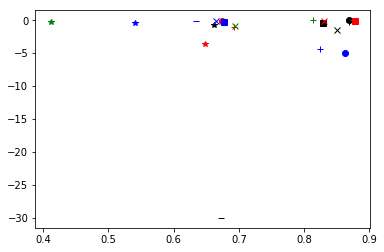

In [4]:
import itertools

# gbest only
pso_name = 'gbest_pso'

# markers = ['o', 'x', '+', 'v', '^', 's']
markers = ['x', '+', '*', 'o', '_', 's']
colors = ['black', 'red', 'blue', 'green']
print (len(markers) * len(colors)), '/', len(benchmark_names)
keys = itertools.product(colors, markers)
keys = itertools.cycle(keys)


for benchmark_name in benchmark_names:
    flc = np.mean(flc_df.transpose()[benchmark_name])
    droc = np.mean(droc_df.transpose()[benchmark_name][pso_name])
    color, marker = keys.next()
    plt.plot(flc, droc, color=color, marker=marker)

plt.show()
    
    

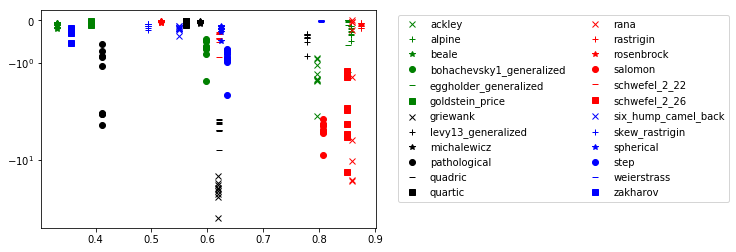

In [13]:
# all psos?

_flcs = []
_drocs = []

for benchmark_name in benchmark_names:
    color, marker = keys.next()
    label = benchmark_name
    
    flc = np.mean(flc_df.transpose()[benchmark_name])
    
    for i, pso_name in enumerate(pso_names):
        droc = np.mean(droc_df.transpose()[benchmark_name][pso_name])    
        plt.plot(flc, droc, linestyle='None', color=color, marker=marker, label=label)
        label = None # Already added to legend for this benchmark
        
        _flcs.append(flc)
        _drocs.append(droc)

_flcs = np.array(_flcs)
_drocs = np.array(_drocs)
from scipy.stats import pearsonr
pearsonr(_flcs, _drocs)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=2)
plt.yscale('symlog')
plt.show()



In [ ]:
plt.